In [97]:
import numpy as np
import pandas as pd
import sklearn
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12,8)

# these are useful plotting functions.
def histogram(df, col_name, bins):
    # look at loan_duration.
    plt.hist(df[col_name], alpha=0.5, label=col_name, bins=bins)
    plt.legend(loc='upper right')
    plt.show()

def barchart(df, col_name):
    df[col_name].value_counts().plot(kind='bar', subplots=False)

def boxplot(df, col_names, by=None):
    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True)
    df.boxplot(column=col_names, return_type='axes', by=by)

def histogram_by_level(df, varName, targetName):
    lvls = df[varName].value_counts()
    for i in lvls.index:
        plt.hist(df[df[varName] == i][targetName], alpha=0.5, label=i, bins=300)

    plt.legend(loc='upper right')
    plt.show()



In [98]:
# load the data to explore. 
account_df = pd.read_pickle('data/account.pkl')
trans_df = pd.read_pickle('data/trans.pkl')
card_df = pd.read_pickle('data/card.pkl')
client_df = pd.read_pickle('data/client.pkl')
disp_df = pd.read_pickle('data/disp.pkl')
district_df = pd.read_pickle('data/district.pkl')
loan_df = pd.read_pickle('data/loan.pkl')
order_df = pd.read_pickle('data/order.pkl')


In [99]:
trans_df.head()

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date
0,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0
1,171812,576,900.0,900.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0
2,207264,704,1000.0,1000.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0
3,1117247,3818,600.0,600.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0
4,579373,1972,400.0,400.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1


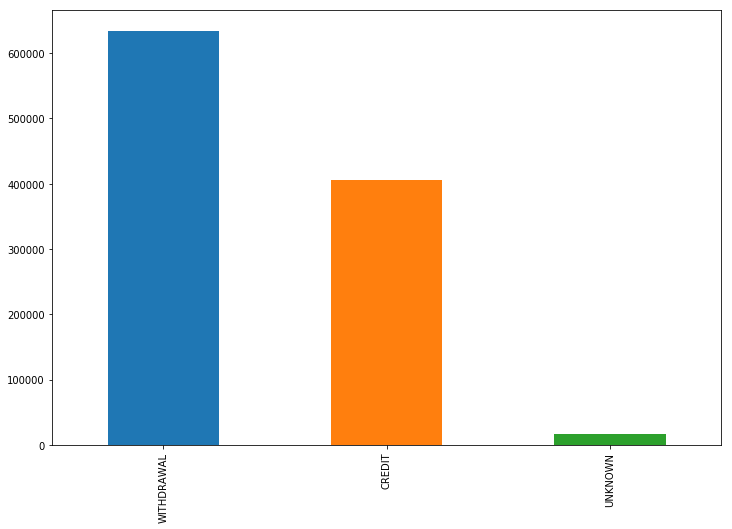

In [100]:
# here we see there are a small number of unknown transaction types.
barchart(trans_df, 'trans_type')

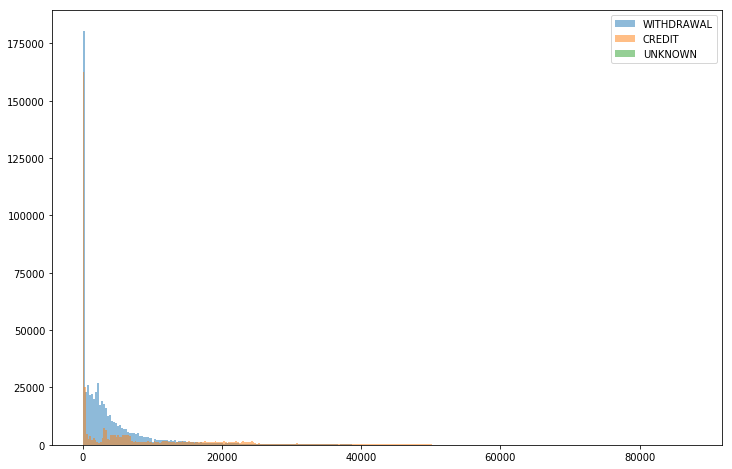

In [101]:
# histogram by transaction type shows the highly skewed nature of transaction amounts.
histogram_by_level(trans_df, 'trans_type', 'trans_amount')

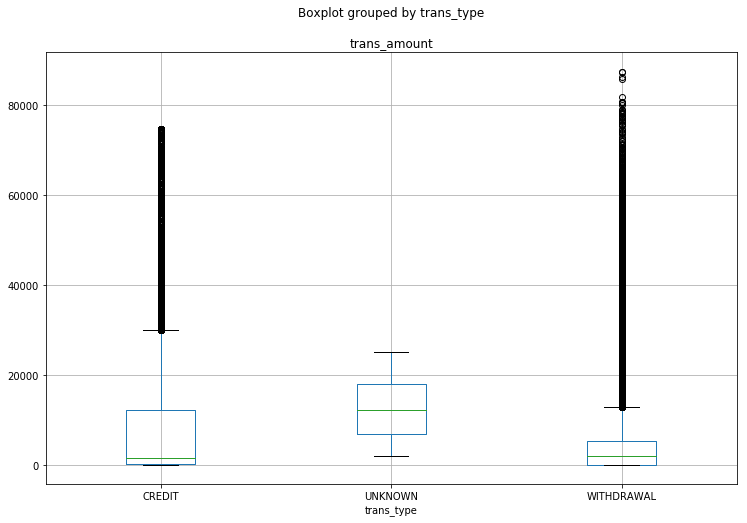

In [11]:
# examining the boxplots we can see that is more heavily skewed for withdrawals than credits.
boxplot(trans_df, ['trans_amount'], by='trans_type')

In [8]:
# examine only the unknown transaction types.
unk_trans_type = trans_df[trans_df['trans_type'] == 'UNKNOWN']

In [9]:
unk_trans_type.head()

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date
994,144918,485,5166.0,88602.9,NaN,NaN,UNKNOWN,WITHDRAWAL_IN_CASH,UNKNOWN,84
1101,144919,485,19168.0,69668.0,NaN,NaN,UNKNOWN,WITHDRAWAL_IN_CASH,UNKNOWN,89
1650,615628,2099,20200.0,27692.5,NaN,NaN,UNKNOWN,WITHDRAWAL_IN_CASH,UNKNOWN,103
1686,144921,485,14491.0,21393.0,NaN,NaN,UNKNOWN,WITHDRAWAL_IN_CASH,UNKNOWN,106
2081,527820,1801,5669.0,71710.8,NaN,NaN,UNKNOWN,WITHDRAWAL_IN_CASH,UNKNOWN,119


In [10]:
# they all are labelled WITHDRAWAL_IN_CASH.
unk_trans_type['trans_operation'].value_counts()

WITHDRAWAL_IN_CASH    16666
Name: trans_operation, dtype: int64

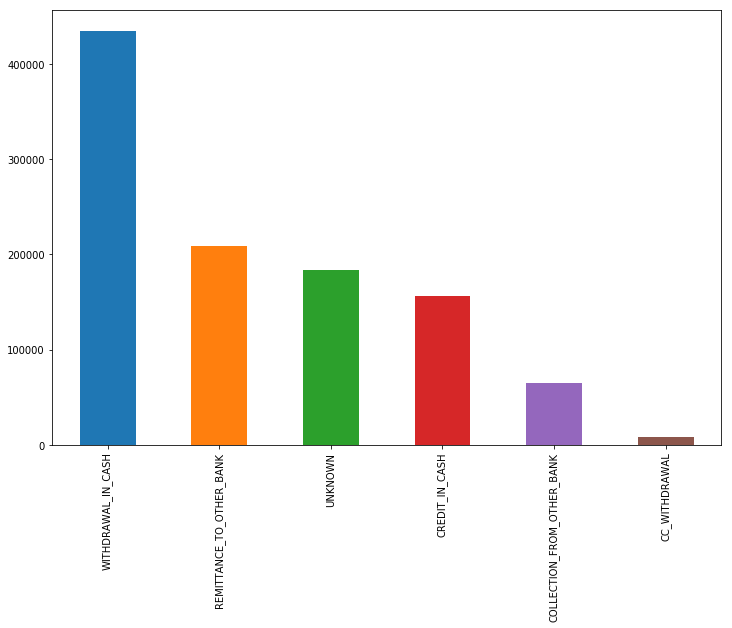

In [102]:
# examine the different trans_operation types. Withdrawal in cash is the most common.
barchart(trans_df, 'trans_operation')

In [12]:
# we see that WITHDRAWAL_IN_CASH has trans_types UNKNOWN or WITHDRAWAL.
gb = trans_df.groupby(['trans_operation', 'trans_type'])
gb['trans_amount'].count()

trans_operation             trans_type
CC_WITHDRAWAL               WITHDRAWAL      8036
COLLECTION_FROM_OTHER_BANK  CREDIT         65226
CREDIT_IN_CASH              CREDIT        156743
REMITTANCE_TO_OTHER_BANK    WITHDRAWAL    208283
UNKNOWN                     CREDIT        183114
WITHDRAWAL_IN_CASH          UNKNOWN        16666
                            WITHDRAWAL    418252
Name: trans_amount, dtype: int64

In [103]:
# Likely fine to set all trans_type = 'UNKNOWN' to 'WITHDRAWAL'
trans_df.loc[trans_df['trans_type'] == 'UNKNOWN', 'trans_type'] = 'WITHDRAWAL'

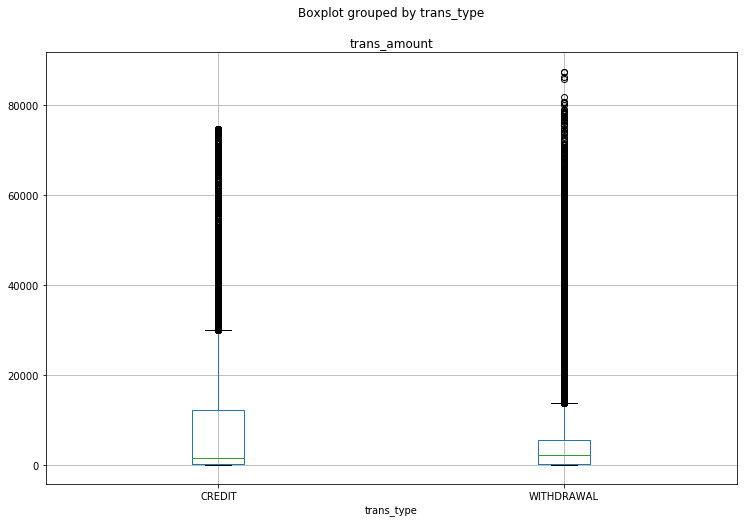

In [104]:
# new boxplot with UNKNOWN trans_type set to WITHDRAWAL. Again, it shows that withdrawals are more skewed than credits.
boxplot(trans_df, ['trans_amount'], by='trans_type')

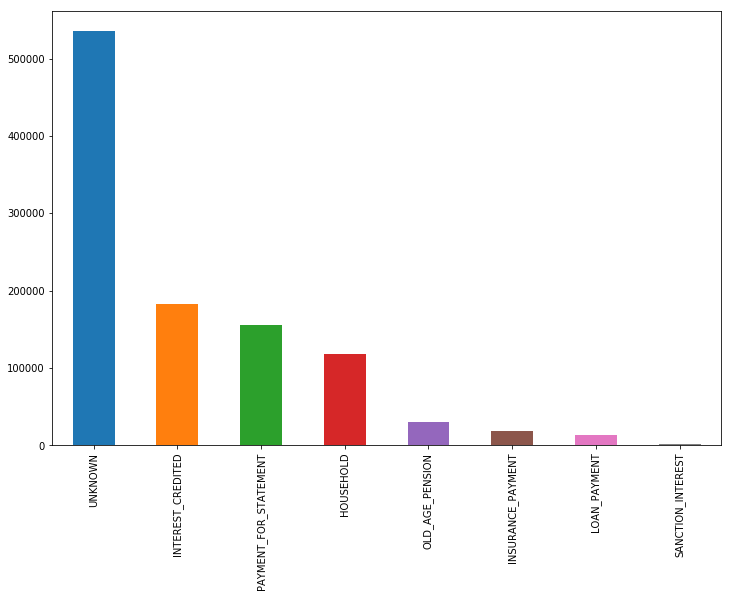

In [105]:
# trans_k_symbol looks to a classification of the purpose of the transaction. Unknown makes up over half of the transacions.
barchart(trans_df, 'trans_k_symbol')

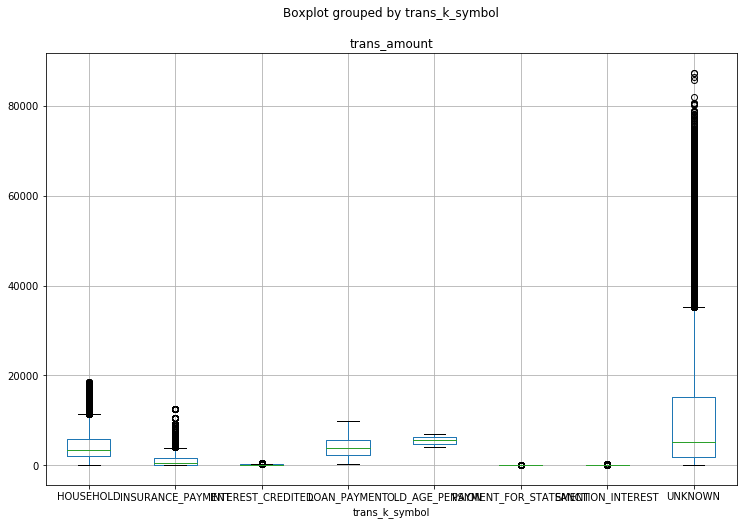

In [13]:
# This boxplot shows that unknown transactions are more highly skewed, which is not surprising.
# One possibility is that we only focus on the transactions we have no information about.
# Household and insurance payment are also skewed as well, but not to the same extent as unknown.
# all the other trans_k_symbols have lower variance and see to be the types which can be ignored.
boxplot(trans_df, ['trans_amount'], by='trans_k_symbol')

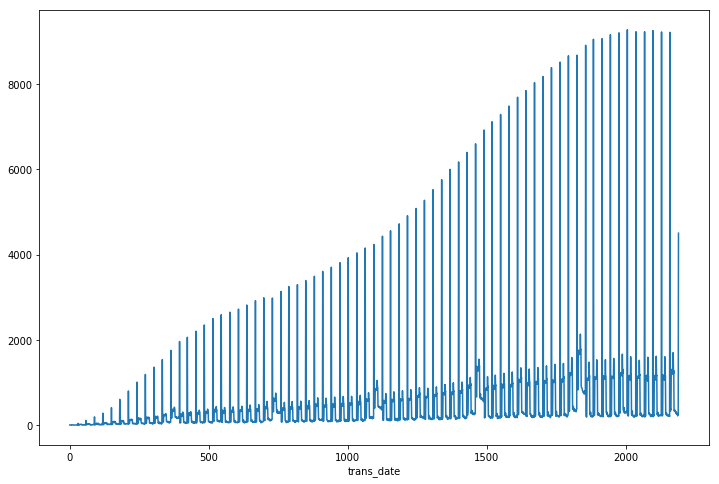

In [106]:
# this graph shows the number of transactions by date. We see a periodic nature perhaps due to regular payments, salary
# and interest credits. We can also see that the number of transactions has grown over the years, which could be due to 
# a larger number of accounts or greater transactions/account.
gb = trans_df.groupby(['trans_date'])
trans_by_date = gb['trans_amount'].count()
trans_by_date.plot(kind='line', subplots=False)


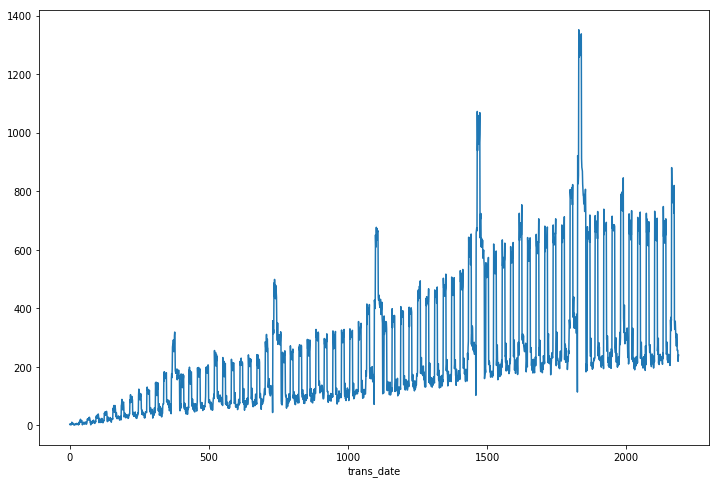

In [107]:
# filtering for only trans_k_symbol = 'UNKNOWN' shows these types of transactions are more heavily skewed than the
# known types. We still see certain seasonality spikes in the graph. There are more transactions occurring in the 
# first two weeks of each month. The first two weeks of January have the most activity. June and December are also months
# where higher than average transaction activity occurs.
gb = trans_df.loc[trans_df['trans_k_symbol'] == 'UNKNOWN'].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].count()
unk_trans_by_date.plot(kind='line', subplots=False)

In [20]:
# seems to be a spike in transactions during the first two weeks of January.
unk_trans_by_date.sort_values(axis=0, ascending=False)[1:50]

trans_date
1839    1338
1837    1320
1838    1309
1834    1307
1835    1304
1831    1302
1833    1279
1836    1266
1832    1259
1465    1073
1474    1069
1470    1059
1467    1001
1471     995
1473     994
1468     986
1472     963
1469     961
1466     939
1826     922
1840     912
1827     889
1841     882
2164     881
1842     875
1843     869
1829     855
1990     846
1828     826
1844     825
1808     823
2173     820
2166     817
2168     814
1805     813
1854     807
2165     806
1799     806
2167     803
1845     801
1986     798
2171     795
1804     795
2170     791
1853     790
1981     790
1806     790
1800     789
1849     789
Name: trans_amount, dtype: int64

In [21]:
unk_trans_by_date.sort_values(axis=0, ascending=False)[50:100]

trans_date
1850    788
1846    786
1847    783
1802    780
1801    777
1803    777
1983    776
1988    768
1984    767
2169    760
1848    757
1807    754
1625    754
2134    748
1985    742
1920    739
1989    737
1982    736
2020    734
1852    734
1987    733
2103    732
1855    732
1851    731
1898    731
2051    729
2073    725
1616    725
2172    725
1478    724
2011    723
1476    722
1870    719
1889    717
1950    715
1778    713
2042    711
2112    708
1686    706
1747    706
1477    706
2110    706
2143    706
2076    705
2018    701
2014    701
2141    700
2136    700
1894    698
2082    696
Name: trans_amount, dtype: int64

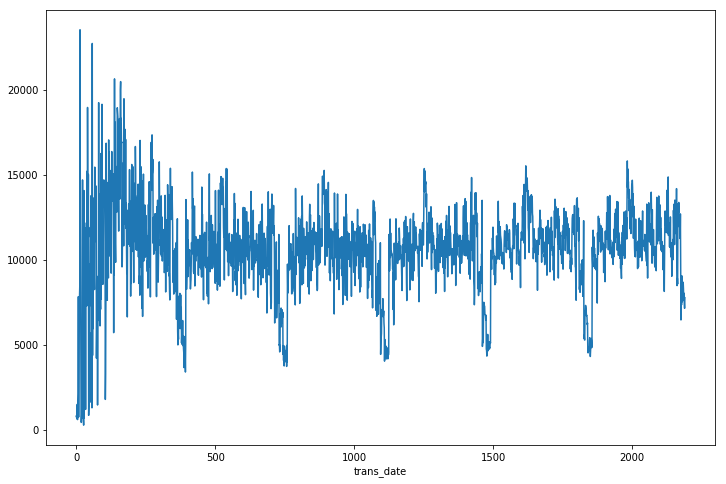

In [108]:
# average transaction size seems to have seasonality affects. The size has been stable during the most recent years.
unk_trans_by_date = gb['trans_amount'].mean()
unk_trans_by_date.plot(kind='line', subplots=False)

In [23]:
# see if there are any interesting dates to look out for.
unk_trans_by_date.sort_values(axis=0, ascending=True)[1:50]

trans_date
18       433.333333
19       450.000000
5        600.000000
3        650.000000
24       700.000000
29       700.000000
2        740.000000
9        750.000000
1        750.000000
26       760.000000
0        800.000000
45       850.000000
20       880.000000
34      1200.000000
6       1260.500000
57      1291.666667
77      1458.333333
4       1500.333333
46      1533.333333
54      1616.666667
105     1787.700000
7       2136.909091
31      3100.000000
106     3299.400000
393     3397.237500
32      3490.000000
388     3659.485207
10      3686.000000
757     3727.325342
748     3753.368231
17      3764.000000
56      3971.428571
759     3982.320388
751     3989.033445
1109    4038.744292
746     4075.517241
22      4085.000000
390     4112.167665
754     4112.760656
753     4112.861290
1115    4164.851117
1121    4170.845000
1111    4197.609813
73      4213.600000
1849    4311.735108
1477    4334.943343
1112    4354.707865
755     4363.443333
59      4375.000000
Name: tra

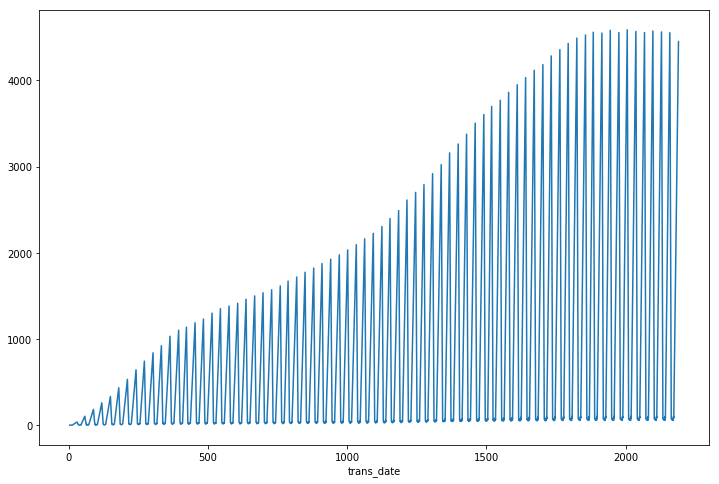

In [110]:
# Look at 'KNOWN' credit transactions. We see a periodic shape, which shows evidence that these are periodic payments that
# are occurring.
gb = trans_df.loc[(trans_df['trans_k_symbol'] != 'UNKNOWN') & (trans_df['trans_type'] == 'CREDIT')].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].count()
unk_trans_by_date.plot(kind='line', subplots=False)

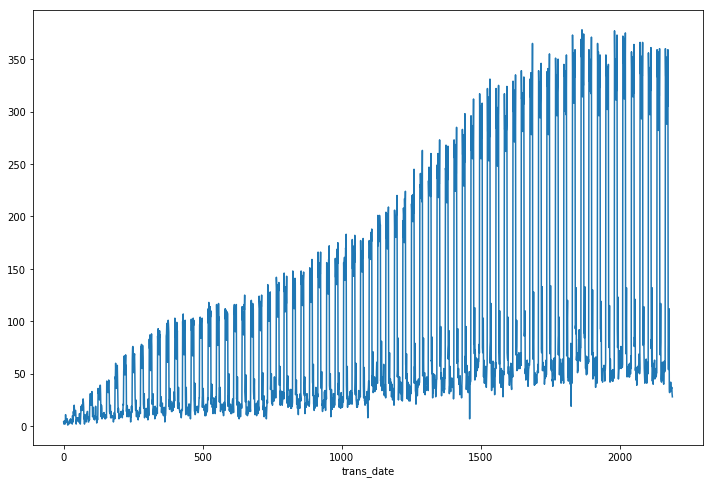

In [109]:
# look at unknown credit transactions. Although the plot is more choppy than the known transactions graph,
# the shape resembles the the known transactions which could indicate that most of the credit activity are 
# periodic occurrences such as salary.
gb = trans_df.loc[(trans_df['trans_k_symbol'] == 'UNKNOWN') & (trans_df['trans_type'] == 'CREDIT')].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].count()
unk_trans_by_date.plot(kind='line', subplots=False)

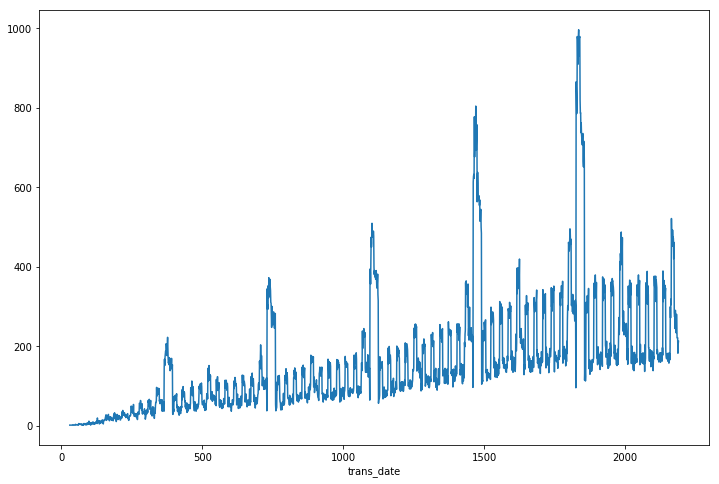

In [111]:
# here we see unknown withdrawals. They are also periodic, but are more highly skewed.
gb = trans_df.loc[(trans_df['trans_k_symbol'] == 'UNKNOWN') & (trans_df['trans_type'] == 'WITHDRAWAL')].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].count()
unk_trans_by_date.plot(kind='line', subplots=False)

In [27]:
unk_trans_by_date.sort_values(axis=0, ascending=True)[1000:1500]

trans_date
795     121
1546    121
1539    122
897     122
1358    122
1297    122
859     122
1515    122
1337    122
1089    122
1323    122
1340    123
825     123
673     123
554     123
1308    123
798     123
1519    123
1542    123
921     124
1860    124
1513    124
860     124
1517    124
829     124
1399    124
1397    124
1512    125
1353    125
769     125
       ... 
2118    174
1601    174
2101    174
1965    174
1674    174
1949    174
1596    174
1938    174
1007    174
2124    175
1226    175
2145    175
1766    175
1582    175
2067    175
888     175
1687    175
1198    175
1785    176
710     176
1767    176
375     176
1658    176
2128    177
1161    177
1787    177
1167    177
1038    177
2037    177
1754    177
Name: trans_amount, Length: 500, dtype: int64

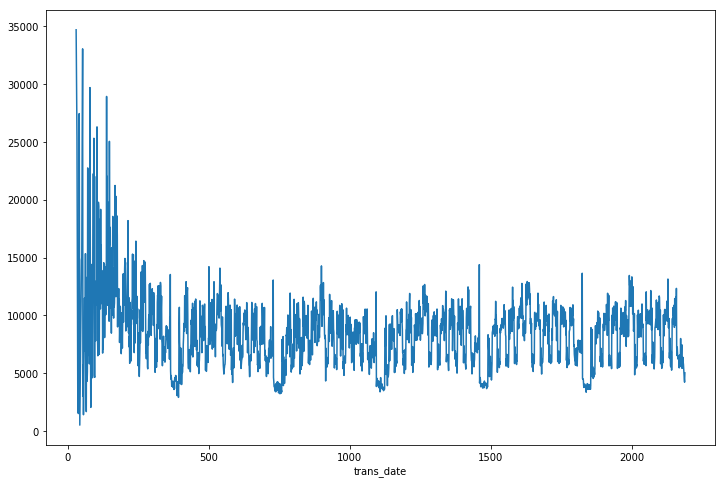

In [112]:
# average transaction size of unknown withdrawals look to be stable during the most recent years.
gb = trans_df.loc[(trans_df['trans_k_symbol'] == 'UNKNOWN') & (trans_df['trans_type'] == 'WITHDRAWAL')].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].mean()
unk_trans_by_date.plot(kind='line', subplots=False)

In [30]:
gb = trans_df.groupby(['trans_type', 'trans_k_symbol'])
gb['trans_amount'].count()

trans_type  trans_k_symbol       
CREDIT      INTEREST_CREDITED        183114
            OLD_AGE_PENSION           30338
            UNKNOWN                  191631
WITHDRAWAL  HOUSEHOLD                118065
            INSURANCE_PAYMENT         18500
            LOAN_PAYMENT              13580
            PAYMENT_FOR_STATEMENT    155832
            SANCTION_INTEREST          1577
            UNKNOWN                  343683
Name: trans_amount, dtype: int64

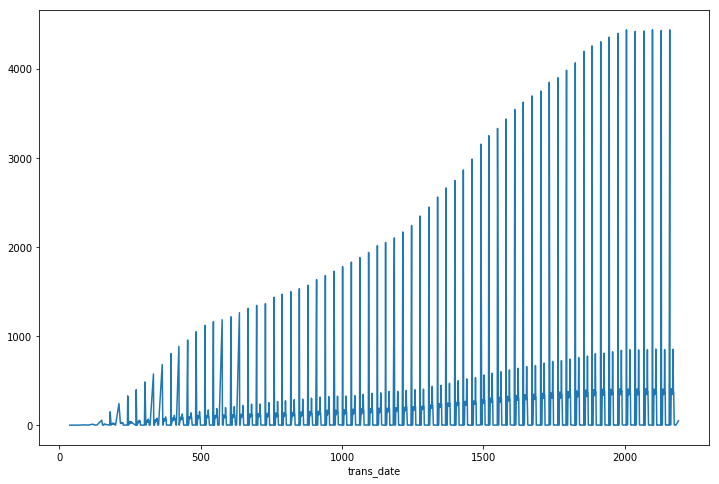

In [113]:
# known withdrawals tend to resemble known credit transactions and are more predictable. Since they tend to be 
# routine payments we will not focus on these types initially.
gb = trans_df.loc[(trans_df['trans_k_symbol'] != 'UNKNOWN') & (trans_df['trans_type'] == 'WITHDRAWAL')].groupby(['trans_date'])
unk_trans_by_date = gb['trans_amount'].count()
unk_trans_by_date.plot(kind='line', subplots=False)

In [32]:
# examine some accounts manually.
account_df.sample(n=15)

,account_id,account_district_id,statement_freq,account_date_opened
3906,2816,74,MONTHLY,1584
1547,1919,18,MONTHLY,702
481,3258,53,MONTHLY,155
535,3786,21,MONTHLY,172
4194,1845,47,MONTHLY,1692
3686,1616,22,MONTHLY,1498
2171,2783,43,MONTHLY,1056
430,991,39,MONTHLY,137
433,2711,58,MONTHLY,138
397,5372,48,MONTHLY,127


In [15]:
# all the transactions that this randomly selected customer made during the time period.
one_acc = trans_df[trans_df['account_id'] == 2872]
one_acc

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date
376404,843716,2872,200.0,200.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1342
377063,843725,2872,12149.0,12349.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1343
392488,3625468,2872,44.6,12393.6,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1368
393314,843938,2872,4900.0,17293.6,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1372
393992,843726,2872,12149.0,29442.6,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1373
410010,3625469,2872,113.5,29556.1,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1399
410712,843939,2872,1600.0,27956.1,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,1402
411589,843727,2872,12149.0,40105.1,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,1404
427927,3625470,2872,161.2,40266.3,NaN,NaN,CREDIT,UNKNOWN,INTEREST_CREDITED,1429
428878,843940,2872,9500.0,30766.3,NaN,NaN,WITHDRAWAL,WITHDRAWAL_IN_CASH,UNKNOWN,1432


In [34]:
# credits seem come in periodically, in the form and new cash and interest. 
# interest is paid at the end of each month.
# new cash usually is paid on the 5th of each month -> salary.
one_acc[one_acc['trans_type'] == 'CREDIT'][['trans_date', 'trans_id', 'trans_type', 'trans_amount', 'trans_operation', 'trans_k_symbol']]

,trans_date,trans_id,trans_type,trans_amount,trans_operation,trans_k_symbol
376404,1342,843716,CREDIT,200.0,CREDIT_IN_CASH,UNKNOWN
377063,1343,843725,CREDIT,12149.0,CREDIT_IN_CASH,UNKNOWN
392488,1368,3625468,CREDIT,44.6,UNKNOWN,INTEREST_CREDITED
393314,1372,843938,CREDIT,4900.0,CREDIT_IN_CASH,UNKNOWN
393992,1373,843726,CREDIT,12149.0,CREDIT_IN_CASH,UNKNOWN
410010,1399,3625469,CREDIT,113.5,UNKNOWN,INTEREST_CREDITED
411589,1404,843727,CREDIT,12149.0,CREDIT_IN_CASH,UNKNOWN
427927,1429,3625470,CREDIT,161.2,UNKNOWN,INTEREST_CREDITED
429984,1434,843728,CREDIT,18224.0,CREDIT_IN_CASH,UNKNOWN
449407,1460,3625471,CREDIT,199.3,UNKNOWN,INTEREST_CREDITED


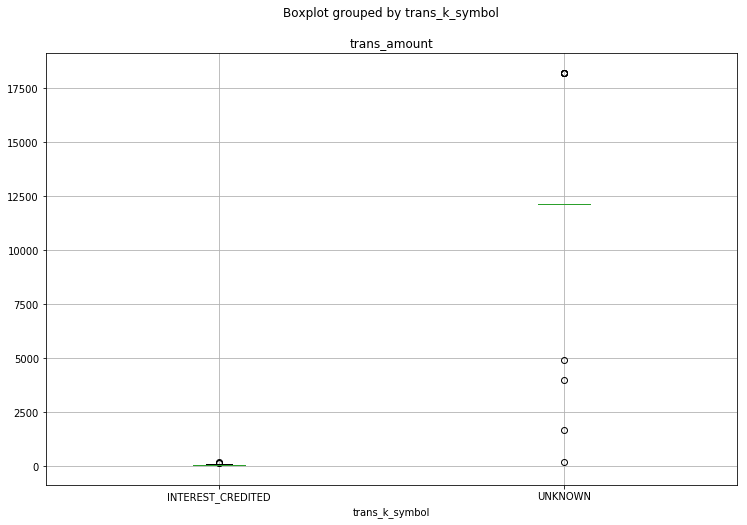

In [16]:
# very small IQR for unknown CREDIT transactions. As seen in the transactions this is likely monthly paychecks.
boxplot(one_acc[(one_acc['trans_type'] == 'CREDIT')], 'trans_amount', by='trans_k_symbol')

In [36]:
# Examine the withdrawal history of the account.
one_acc[one_acc['trans_type'] == 'WITHDRAWAL'][['trans_date', 'trans_id', 'trans_type', 'trans_amount', 'trans_operation', 'trans_k_symbol']]

,trans_date,trans_id,trans_type,trans_amount,trans_operation,trans_k_symbol
410712,1402,843939,WITHDRAWAL,1600.0,WITHDRAWAL_IN_CASH,UNKNOWN
428878,1432,843940,WITHDRAWAL,9500.0,WITHDRAWAL_IN_CASH,UNKNOWN
450847,1462,843941,WITHDRAWAL,13200.0,WITHDRAWAL_IN_CASH,UNKNOWN
453444,1465,843877,WITHDRAWAL,2760.0,WITHDRAWAL_IN_CASH,UNKNOWN
456025,1467,843837,WITHDRAWAL,4500.0,WITHDRAWAL_IN_CASH,UNKNOWN
457347,1468,843765,WITHDRAWAL,4040.0,REMITTANCE_TO_OTHER_BANK,HOUSEHOLD
458588,1469,843801,WITHDRAWAL,4059.0,REMITTANCE_TO_OTHER_BANK,UNKNOWN
464171,1473,843881,WITHDRAWAL,1200.0,WITHDRAWAL_IN_CASH,UNKNOWN
470954,1482,843865,WITHDRAWAL,8480.0,WITHDRAWAL_IN_CASH,UNKNOWN
470956,1482,843879,WITHDRAWAL,1920.0,WITHDRAWAL_IN_CASH,UNKNOWN


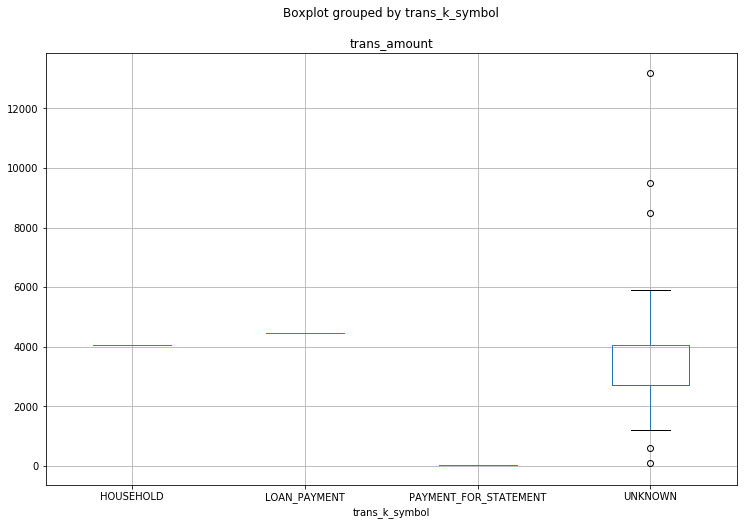

In [17]:
# Withdrawals are more skewed than the other types.
boxplot(one_acc[(one_acc['trans_type'] == 'WITHDRAWAL')], 'trans_amount', by='trans_k_symbol')

In [115]:
# - Known transactions (loan payments, interest, etc...) tend to be periodic and more predictable than unknown.

# - Transaction count for both credit and withdrawals are seasonal in nature.

# - Unknown withdrawal and credit transaction types are quite different in nature. Both display seasonality patters 
#   but withdrawals are more highly skewed and less predictable. 

# - A large part of the unknown credit transactions include routine payments like salary.

# - Average transaction amount is also seasonal but has been stable over time.

# - An withdrawal anomaly would have different characteristics than a credit anomaly.
# - look at only unknown transactions.


In [114]:
# merge transactions with account and district information.
trans_account_df = pd.merge(trans_df, account_df, on='account_id', how='inner')
print(trans_account_df.shape)
print(trans_df.shape)

trans_district_df = pd.merge(trans_account_df, district_df, left_on='account_district_id', right_on='district_id', how='inner') # verify if it joined correctly!
print(trans_district_df.shape)

del trans_account_df
del trans_df

(1056320, 13)
(1056320, 10)
(1056320, 31)


In [39]:
trans_district_df.head()

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date,...,num_cities,ratio_urban,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96,crimes_per1000_95,crimes_per1000_96
0,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0,...,8,56.9,8427,1.12,1.54,107,1874,1913,19.950815,20.366013
1,695250,2378,7268.0,7968.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,21,...,8,56.9,8427,1.12,1.54,107,1874,1913,19.950815,20.366013
2,695266,2378,14440.0,22408.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,22,...,8,56.9,8427,1.12,1.54,107,1874,1913,19.950815,20.366013
3,695262,2378,49752.0,72160.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,23,...,8,56.9,8427,1.12,1.54,107,1874,1913,19.950815,20.366013
4,695265,2378,21899.0,94059.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,25,...,8,56.9,8427,1.12,1.54,107,1874,1913,19.950815,20.366013


In [40]:
# create a features that look at past five days transaction amounts and transaction counts.
def get_rolling_trx_sum(trx_amounts):
    l = len(trx_amounts)
    ret_df = pd.DataFrame({'trans_id':np.zeros(l), 'sum5':np.zeros(l), 'cnt5':np.zeros(l)})
    
    for i in range(l):
        
        ret_df.loc[i, 'trans_id'] = trx_amounts.iloc[i]['trans_id']
        if i == 0:
            ret_df.loc[i, 'sum5'] = 0
            ret_df.loc[i, 'cnt5'] = 0
        else:
            curr_trx_date = trx_amounts.iloc[i]['trans_date']
            
            sum5 = trx_amounts.loc[(trx_amounts['trans_date'] < curr_trx_date) & 
                                   (trx_amounts['trans_date'] > (curr_trx_date-5))]['trans_amount'].sum()
            cnt5 = trx_amounts.loc[(trx_amounts['trans_date'] < curr_trx_date) & 
                                   (trx_amounts['trans_date'] > (curr_trx_date-5))]['trans_amount'].count()
            #sum5 = 0
            #cnt5 = 0
            #j = i - 1        
            #while j >= 0:
            #    prev_trx_date = trx_amounts.iloc[j]['trans_date']
            #    if (curr_trx_date - prev_trx_date) > 5:
            #        break
            #    sum5 = sum5 + trx_amounts.iloc[j]['trans_amount']
            #    j = j - 1
            ret_df.loc[i, 'sum5'] = sum5
            ret_df.loc[i, 'cnt5'] = cnt5
    return ret_df


In [42]:
# select only unknown transactions.
unk_trans_district_df = trans_district_df[trans_district_df['trans_k_symbol'] == 'UNKNOWN']
unk_trans_district_df.to_pickle('data/unk_trans_district_df.pkl')

In [ ]:
# create the rolling amount features by applying the function on the dataset. Takes a while!
gb = unk_trans_district_df.groupby(['account_id'])
rolling_cnts = gb.apply(get_rolling_trx_sum)
rolling_cnts.head(n=20)

In [125]:
rolling_cnts.to_pickle('data/rolling_cnts.pkl')

In [43]:
# join the created features with the dataset.
rolling_cnts = pd.read_pickle('data/rolling_cnts.pkl')
df = pd.merge(unk_trans_district_df, rolling_cnts, on='trans_id', how='inner')
df.head()

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date,...,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96,crimes_per1000_95,crimes_per1000_96,cnt5,sum5
0,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,0.0,0.0
1,695250,2378,7268.0,7968.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,21,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,0.0,0.0
2,695266,2378,14440.0,22408.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,22,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,1.0,7268.0
3,695262,2378,49752.0,72160.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,23,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,2.0,21708.0
4,695265,2378,21899.0,94059.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,25,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,3.0,71460.0


In [44]:
print(unk_trans_district_df.shape)
print(df.shape)
df.to_pickle('data/df.pkl')

(535314, 31)
(535314, 33)


In [83]:
# Examine the distribution of the districts salary. The hypothesis is that higher salaries would result in higher
# transaction amounts, so it would make sense to segment (peer group) based on salary.
district_df['average_salary'].describe()

count       77.000000
mean      9031.675325
std        790.202347
min       8110.000000
25%       8512.000000
50%       8814.000000
75%       9317.000000
max      12541.000000
Name: average_salary, dtype: float64

In [20]:
df = pd.read_pickle('data/df.pkl')
#df['trans_amount_perc'] = df['trans_amount']/(df['balance_after_trans'] + df['trans_amount'])
#to_replace_dict = {'trans_type': {'CREDIT':0, 'WITHDRAWAL':1}}
#df.replace(to_replace_dict, inplace=True)

In [21]:
# let's only analyze the credit transactions with lower salary districts.
df = df[(df['trans_type'] == 'CREDIT') & (df['average_salary'] <= 8814)]
df.head()

,trans_id,account_id,trans_amount,balance_after_trans,trans_bank_partner,trans_account_partner,trans_type,trans_operation,trans_k_symbol,trans_date,...,average_salary,unemp_rate95,unemp_rate96,num_entrep_per1000,num_crimes95,num_crimes96,crimes_per1000_95,crimes_per1000_96,cnt5,sum5
0,695247,2378,700.0,700.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,0,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,0.0,0.0
1,695250,2378,7268.0,7968.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,21,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,0.0,0.0
2,695266,2378,14440.0,22408.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,22,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,1.0,7268.0
3,695262,2378,49752.0,72160.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,23,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,2.0,21708.0
4,695265,2378,21899.0,94059.0,NaN,NaN,CREDIT,CREDIT_IN_CASH,UNKNOWN,25,...,8427,1.12,1.54,107,1874,1913,19.950815,20.366013,3.0,71460.0


In [30]:
# will scale sums and amounts.
trans_ids = df['trans_id']
cnts = df['cnt5']
X = df[['sum5', 'trans_amount']]

print(trans_ids.shape)
print(cnts.shape)
print(X.shape)

(74494,)
(74494,)
(74494, 2)


In [31]:
# import DBSCAN package and do standard scaling.
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [43]:
X = np.append(X,cnts.as_matrix().reshape(74494,1),axis=1)

In [87]:
# function that creates a scatterplot with coloured labels.
def scatter_plot(df, x_colname, y_colname, label_colname, num_labels):
    # setup the plot
    fig, ax = plt.subplots(1,1, figsize=(12,8))
    # define the data
    x = test[x_colname]
    y = test[y_colname]
    tag = test[label_colname] + 1

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0,num_labels,num_labels+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # make the scatter
    scat = ax.scatter(x,y,c=tag,cmap=cmap,     norm=norm)
    # create the colorbar
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax.set_title('Discrete color mappings')
    plt.show()

In [ ]:
#
# DBSCAN is an algorithm that aims to find clusters of arbitrary shape. It claims to be resistant to noise (outliers)
# so it could be useful in detecting certain anomalies.
#
# There are two hyperparameters for the algorithm:
#  eps: maximum distance between two points for them to be considered in the same cluster. Neighbourhood radius.
#  min_samples: minimum number of samples in the neighborhood of a point in order to flag the point as belonging to a cluster.
#
# If a neighbour of a point is already part of a cluster, the point is added to the cluster. Otherwise a new cluster is created.
#
# Below we will try different min_samples of DBSCAN and see how many outliers it determines and what types of transactions are
# flagged.

In [89]:
# the default distance measure is Euclidean distance.
# min_samples = 10.
db = DBSCAN(eps=0.5, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_unique_labels = len(set(labels))
n_clusters_ = num_unique_labels - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of outliers: {}'.format(np.where(labels == -1)[0].shape[0]))

Estimated number of clusters: 12
Estimated number of outliers: 369


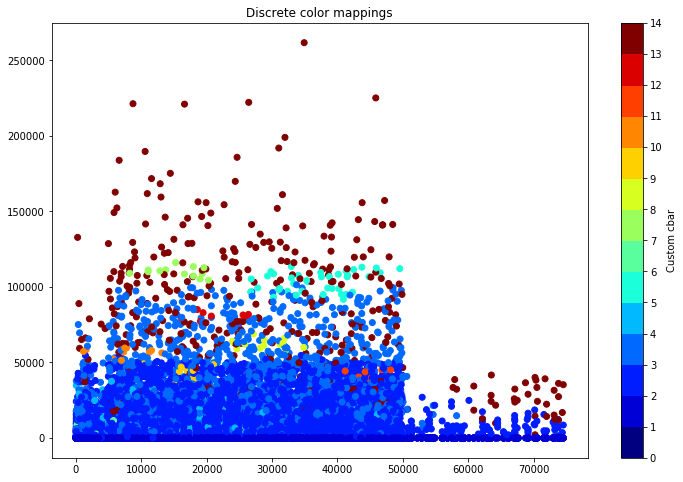

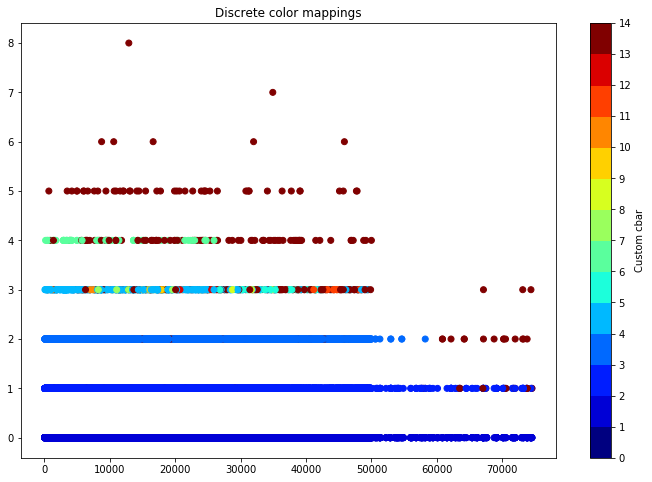

In [90]:
labels[np.where(labels == -1)] = n_clusters_

# do some plots on the original dataset.
test = df[['sum5', 'cnt5', 'trans_amount']].copy()
test['label'] = labels

scatter_plot(test, 'trans_amount', 'sum5', 'label', num_unique_labels+1)
scatter_plot(test, 'trans_amount', 'cnt5', 'label', num_unique_labels+1)

In [91]:
# try DBSCAN with min_samples = 5.
db = DBSCAN(eps=0.5, min_samples=5).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_unique_labels = len(set(labels))
n_clusters_ = num_unique_labels - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of outliers: {}'.format(np.where(labels == -1)[0].shape[0]))

Estimated number of clusters: 10
Estimated number of outliers: 189


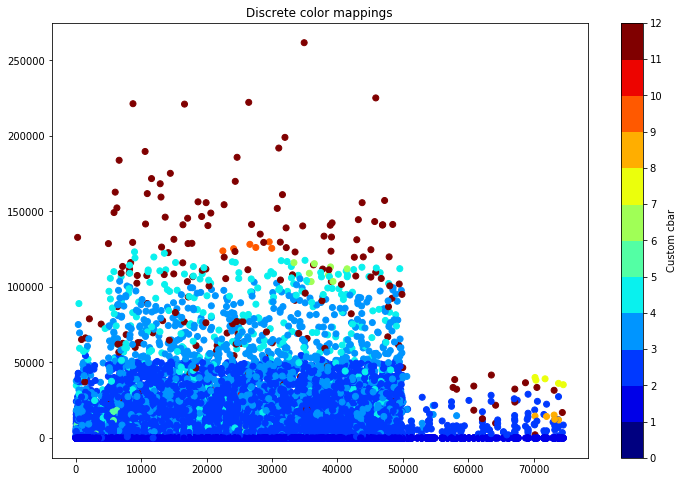

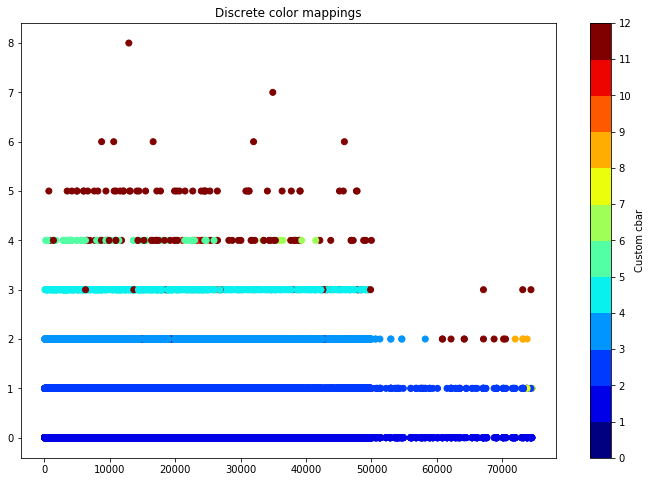

In [92]:
labels[np.where(labels == -1)] = n_clusters_

# do some plots on the original dataset.
test = df[['sum5', 'cnt5', 'trans_amount']].copy()
test['label'] = labels

scatter_plot(test, 'trans_amount', 'sum5', 'label', num_unique_labels+1)
scatter_plot(test, 'trans_amount', 'cnt5', 'label', num_unique_labels+1)

In [93]:
# try DBSCAN with min_samples = 3.
db = DBSCAN(eps=0.5, min_samples=3).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_unique_labels = len(set(labels))
n_clusters_ = num_unique_labels - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of outliers: {}'.format(np.where(labels == -1)[0].shape[0]))

Estimated number of clusters: 26
Estimated number of outliers: 117


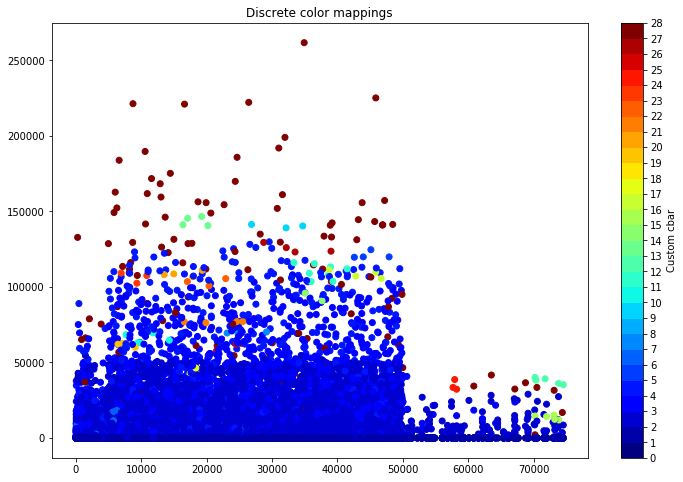

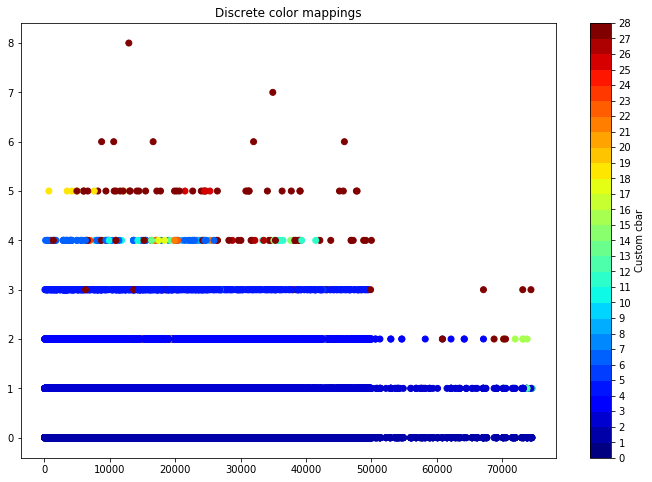

In [94]:
labels[np.where(labels == -1)] = n_clusters_

# do some plots on the original dataset.
test = df[['sum5', 'cnt5', 'trans_amount']].copy()
test['label'] = labels

scatter_plot(test, 'trans_amount', 'sum5', 'label', num_unique_labels+1)
scatter_plot(test, 'trans_amount', 'cnt5', 'label', num_unique_labels+1)

In [95]:
db = DBSCAN(eps=0.5, min_samples=20).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
num_unique_labels = len(set(labels))
n_clusters_ = num_unique_labels - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of outliers: {}'.format(np.where(labels == -1)[0].shape[0]))

Estimated number of clusters: 5
Estimated number of outliers: 651


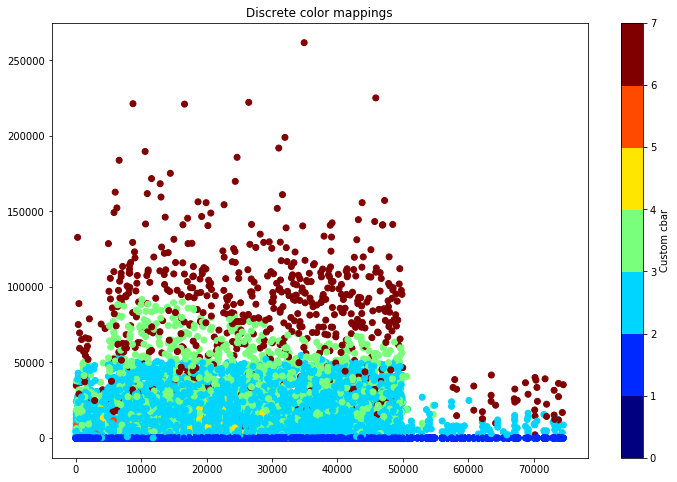

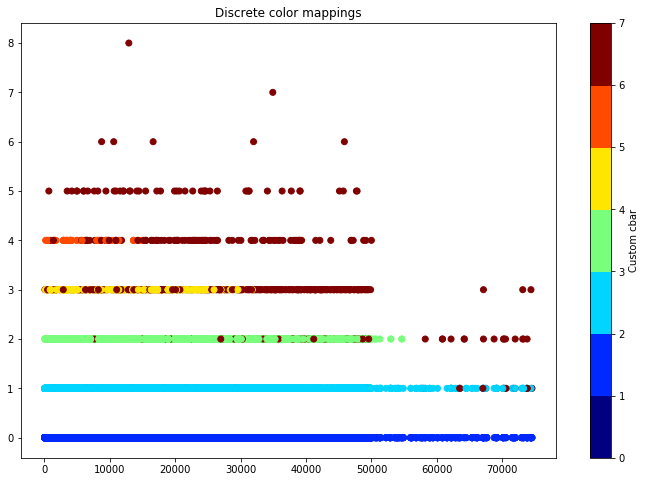

In [96]:
labels[np.where(labels == -1)] = n_clusters_

# do some plots on the original dataset.
test = df[['sum5', 'cnt5', 'trans_amount']].copy()
test['label'] = labels

scatter_plot(test, 'trans_amount', 'sum5', 'label', num_unique_labels+1)
scatter_plot(test, 'trans_amount', 'cnt5', 'label', num_unique_labels+1)